# CSCI 0333 Final Project 

## Overview 
My project seeks to investigate the accuracy of IBM's quantum computer, which is available for use through the qiskit package. I do this by analyzing a circuit that passes the input qubits through a Quantum Fourier Transform (QFT) and then an inverse Quantum Fourier Transform (IQFT). In the absence of any error, we expect the measurement of the final state to be the same as the initial input state. Using this assumption, I run the QFT IQFT circuit on one of IBM's quantum processing units (QPUs) for 5000 shots get a dictionary of the counts of each output as the return value. Based on the counts, I calculate the percentage of correct outputs (where the measured state is all zeroes). I repeat this process with an increasing number of qubits being passed into the QFT and analyze how the accuracy decreases. I also run the circuit on a classical simulator, which returns the correct output 100% of the time with up to 29 qubits. As the number of qubits increases, the accuracy appears to decrease exponentially, likely because adding a single qubit greatly increases the number of superposition states and total possible outcomes (2^n possibilites where n is the number of qubits) and increases the number of gates needed, which also increases the possibility of error. While impressive that we are able to run simulations on a quantum computer with today's technology, this analysis could indicate that we still have a ways to go before quantum computers can be effectively implemented.

### Side Note
The original intent of this project was to implement Shor's algorithm and perform a similar analysis to the one we did. Due to time contraints and a difficulty generalizing the oracle used in Shor's algorithm, I was unable to do so. The work I did for that can be found in the repository for this project at https://github.com/omar-armbruster/IBM-QPU-Testing 

### Sources
<b>Running circuit on quantum computer and basic circuitry<b>\
https://docs.quantum.ibm.com/guides/hello-world \
Running circuit on simulator \
https://www.youtube.com/watch?v=YqHbmOARKM4 \
Quantum Fourier Transform \
https://quantumcomputinguk.org/tutorials/quantum-fourier-transform-in-qiskit \
IBM QPU Dashboard \
https://quantum.ibm.com/

In [1]:
## Notebook to verify that QFT-1QFT|x> = |x>

import numpy as np
from qiskit import *
from qiskit_aer import *
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [102]:
def QFTINVQFT(numQB, init = [], shots = 2000):
    """
    Defines the QFT, IQFT Circuit and runs the circuit on the qasm simulator
    Parameters:
        numQB: An integer representing the number of qubits used
        init: A list where the values represent the indexes of the qubits to be flipped from a 0 to 1 in the initial state
        shots: The number of times the circuit should be run on the simulator 
    Returns:
        counts: A dictionary containing all measured bitstrings and the frequency that they were measured
    """
    qc = QuantumCircuit(numQB,numQB)
    for bit in init:
        qc.x(bit)
    qft = QFT(num_qubits=numQB, approximation_degree=0).to_gate()
    invqft = QFT(num_qubits=numQB, approximation_degree=0, inverse=True).to_gate()
    qc.append(qft, qargs=range(0,numQB))
    qc.append(invqft, qargs=range(0,numQB))
    qc.measure_all()
    simulator = Aer.get_backend("qasm_simulator")
    transpiler = transpile(qc, backend=simulator)
    result = simulator.run(transpiler, shots=shots).result()
    counts = result.get_counts()
    for key in counts.keys():
        counts[key] = counts[key]/shots
    return counts, qc

# Simulator

{'01001100 00000000': 1.0}


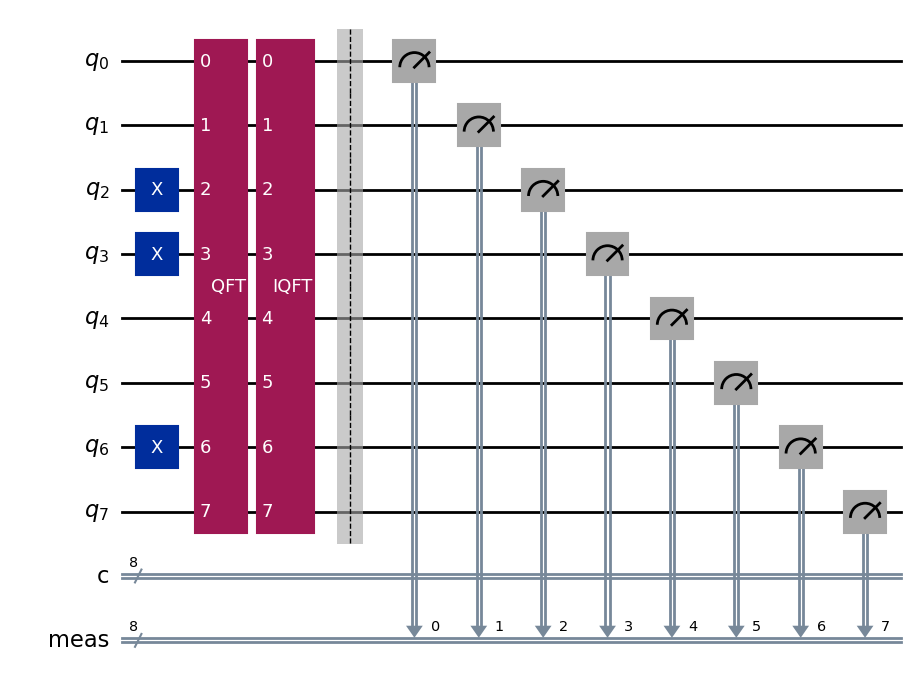

In [107]:
counts1, qc1 = QFTINVQFT(8, [2,3, 6], 10000)
print(counts1)
qc1.draw("mpl")

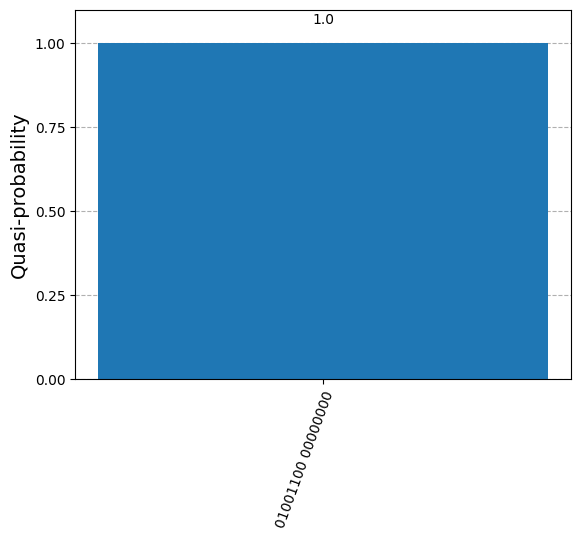

In [108]:
plot_histogram(counts1)
# We get the correct output 100% of the time using the qasm simulator

# Quantum Computer 

{'00 00': 1.0}


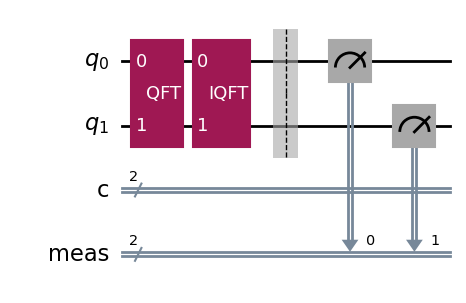

In [103]:
# Initialize quantum circuit
numQubits = 2
counts2, qc2 = QFTINVQFT(numQubits, shots = 5000)
print(counts2)
qc2.draw("mpl")

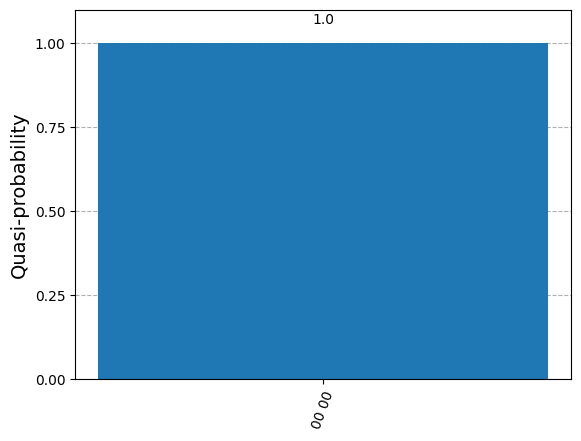

In [104]:
# Verify simulator is 100% accurate
plot_histogram(counts2)

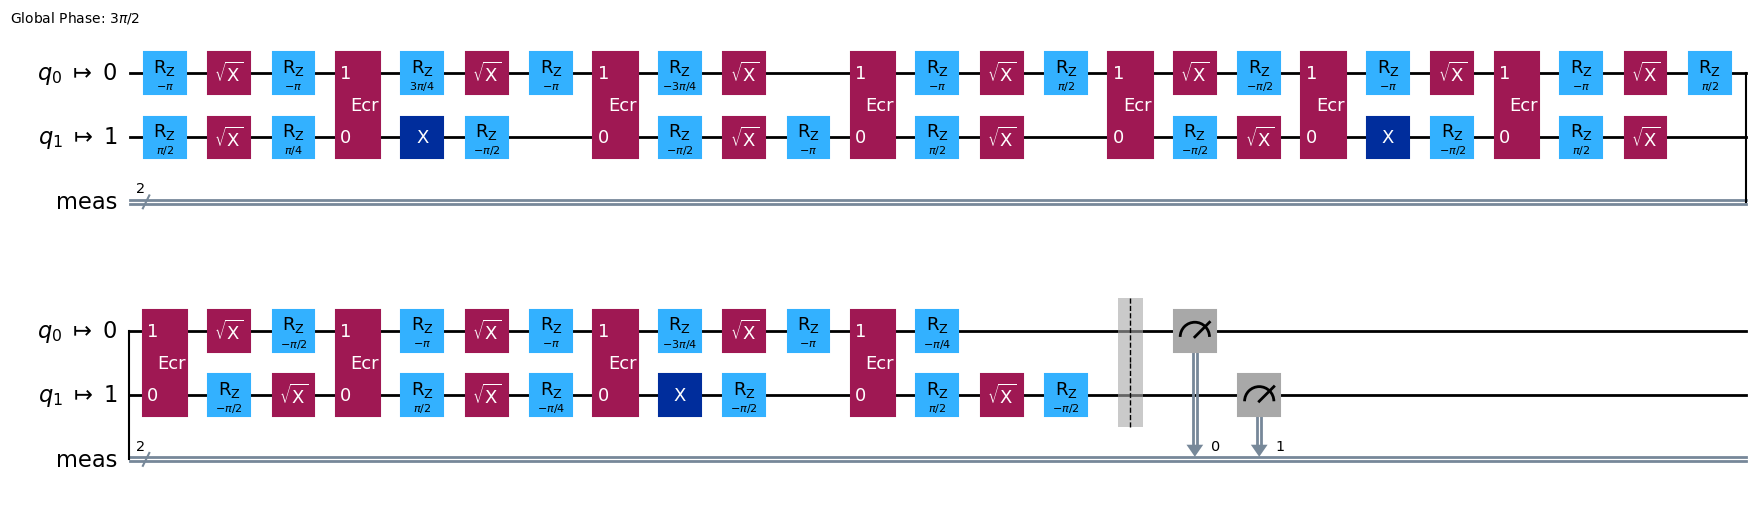

In [105]:
#Initialize runtimeservice to connect to QPU (Adapted from IBM tutorial)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc2)
 
isa_circuit.draw("mpl", idle_wires=False)

In [51]:
# Construct sampler to make sure output is measured in terms of bitstrings and their frequencies
 
sampler = Sampler(mode=backend)
sampler.options.default_shots = 5000

# Run code on QPU
job = sampler.run([(isa_circuit)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cx8js5wztp30008fy9hg


{'000': 4171, '110': 197, '111': 41, '001': 100, '100': 176, '101': 44, '010': 262, '011': 9}


Text(0.5, 1.0, 'Quantum Computer Results for 3-Qubit System')

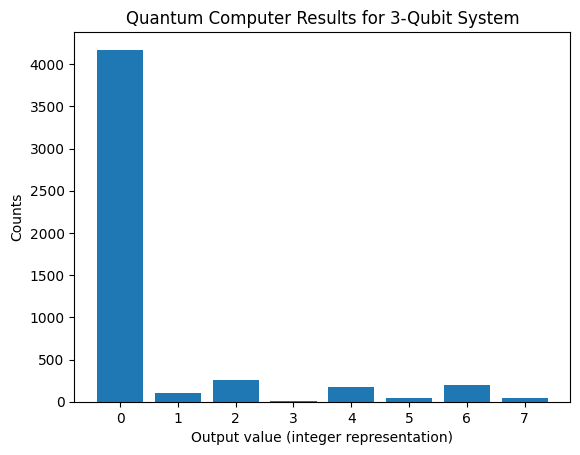

In [53]:
# Plot counts of each output returned by QPU. A perfect result would contain all zeroes.
result = job.result()
print(result[0].data.meas.get_counts())
# plot_histogram(result[0].data.meas.get_counts(), sort ='value_desc')
counts = result[0].data.meas.get_counts()
ints = [int(i, 2) for i in counts.keys()]
plt.bar(ints, counts.values())
plt.xlabel('Output value (integer representation)')
plt.ylabel('Counts')
plt.title(f'Quantum Computer Results for {numQubits}-Qubit System')

# Analysis

In [112]:
# Load all trials performed
service = QiskitRuntimeService()
jobList = ["cx8jg0rtpsjg008c92m0","cx19k7mztp30008es7k0", "cx19hjepjw300082tdwg", "cx199f5bqkhg0083m4g0", "cx17zjeztp30008es4fg", "cx8jdzfbqkhg0088wk00", "cx8j0paztp30008fy6m0", "cx8jktfztp30008fy8w0", "cx8jndxztp30008fy920", "cx8jpvktpsjg008c93fg", "cx8js5wztp30008fy9hg"]
dicts = []
for jobId in jobList:
    result = service.job(jobId).result()[0].data.meas.get_counts()
    dicts.append(result)

In [113]:
# Calculate the percentage of correct measurements for each trial
lengths = []
frac = []
for counts in dicts:
    length = len(list(counts.keys())[0])
    lengths.append(length)
    bitString = length*'0'
    if bitString in counts.keys():
        frac.append(counts[bitString]/5000)
    else:
        frac.append(0)

In [114]:
def plotHisto(frequencies):
    """
    Histogram for QPU output frequencies. Converts bitstrings to an integer representation.
    Parameters:
        frequencies: A dictionary containing the bitstring measurements and the number of times that they are measured.
    """
    ints = [int(i, 2) for i in frequencies.keys()]
    length = len(list(frequencies.keys())[0])
    plt.bar(ints, frequencies.values())
    plt.xlabel('Output value (integer representation)')
    plt.ylabel('Counts')
    plt.title(f'Quantum Computer Results for {length}-Qubit System')
    plt.show()

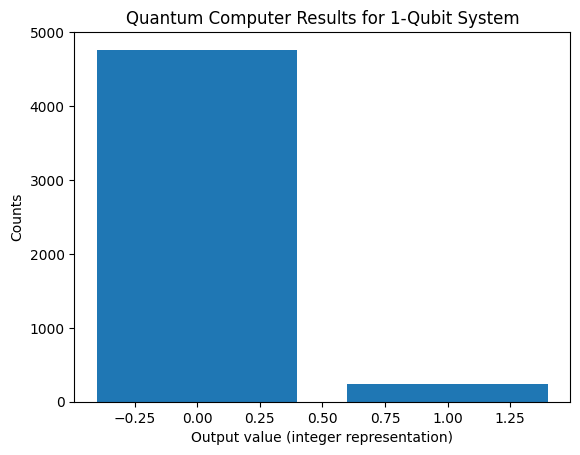

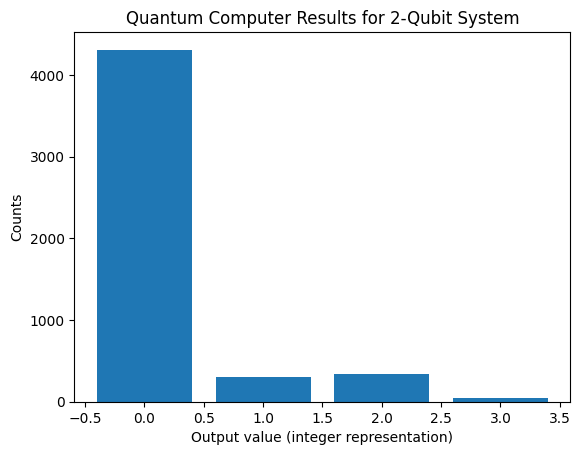

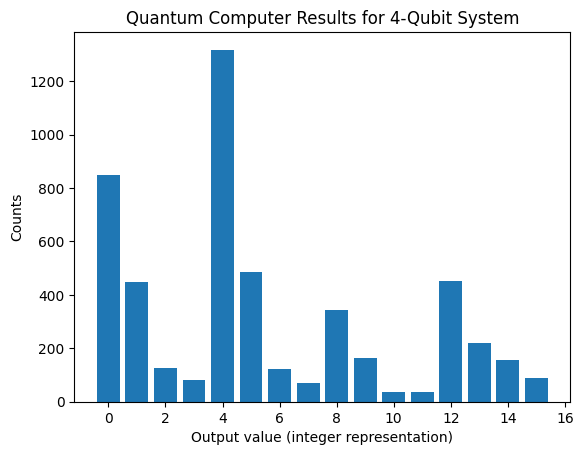

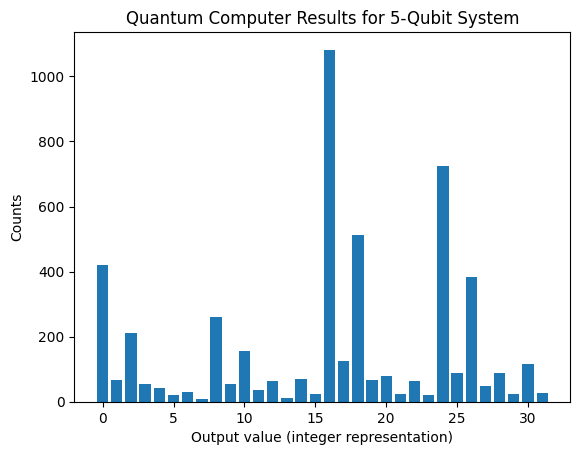

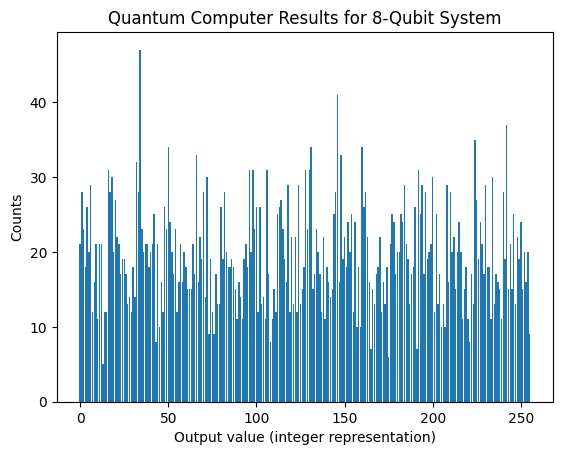

In [115]:
plotHisto(dicts[8])
plotHisto(dicts[9])
plotHisto(dicts[1])
plotHisto(dicts[2])
plotHisto(dicts[3])

Text(0.5, 1.0, 'Accuracy of IBM Quantum Computer on QFT INVQFT |x>')

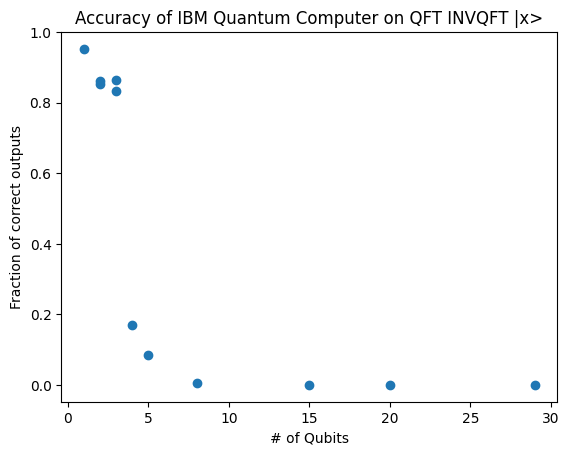

In [116]:
#Plot percentage of correct measurements over all trials
fig = plt.figure()
plt.scatter(lengths, frac)
plt.xlabel('# of Qubits')
plt.ylabel('Fraction of correct outputs')
plt.title('Accuracy of IBM Quantum Computer on QFT INVQFT |x>')

In [117]:
for (i, j) in sorted(zip(lengths, frac), key=lambda x: x[0]):
    print(f"The accuracy is {j*100}% for {i} qubits")

The accuracy is 95.26% for 1 qubits
The accuracy is 85.2% for 2 qubits
The accuracy is 86.16% for 2 qubits
The accuracy is 86.48% for 3 qubits
The accuracy is 83.42% for 3 qubits
The accuracy is 17.0% for 4 qubits
The accuracy is 8.4% for 5 qubits
The accuracy is 0.42% for 8 qubits
The accuracy is 0% for 15 qubits
The accuracy is 0% for 20 qubits
The accuracy is 0% for 29 qubits


In [118]:
def errorTolerance(qubitNum, dicts, lengths):
    """
    Calculates the accuracy of the QPU where qubitNum errors are allowed in the final measurement. For example, when qubitNum = 1, any measurement
    with 1 incorrect qubit would be considered correct.
    Parameters:
        qubitNum: the number of qubit errors allowed in the final measurement 
        dicts: The frequency dictionaries containing counts for each measured bitstring for each trial
        lengths: The corresponding number of qubits for each dictionary in dicts
    Returns: A list containing the error-tolerant accuracies for each trial in dicts.
    """
    onefrac = []
    for counts in dicts:
        right = 0
        for key in counts.keys():
            value = 0
            for char in key:
                value += int(char)
            if value <=qubitNum:
                right += counts[key]
        onefrac.append(right/5000)
    plt.scatter(lengths, onefrac)
    plt.title(f'Accuracy of IBM Quantum Computer with {qubitNum}-qubit error allowance')
    plt.xlabel('# of Qubits')
    plt.ylabel('Fraction of correct outputs')
    plt.show()
    return onefrac
        

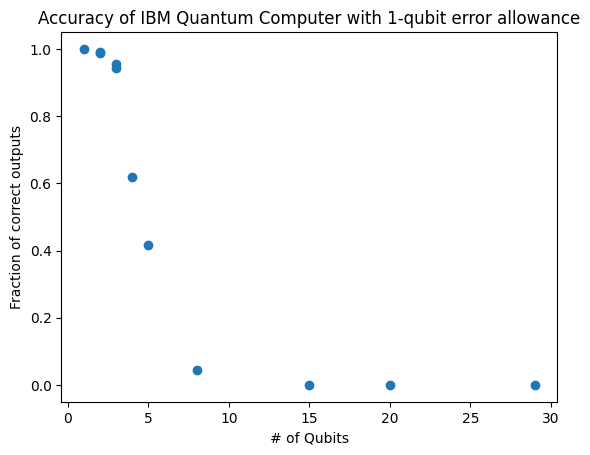

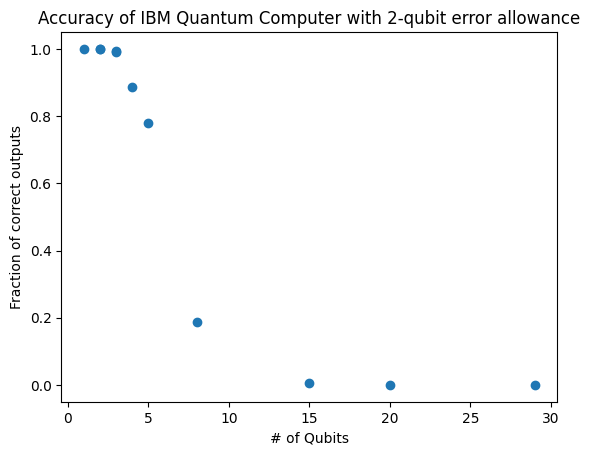

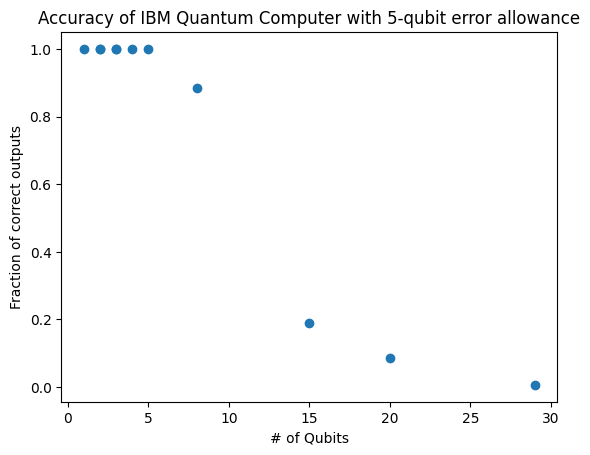

[1.0, 1.0, 1.0, 0.8854, 1.0, 0.1898, 0.0064, 0.0854, 1.0, 1.0, 1.0]

In [119]:
errorTolerance(1, dicts, lengths)
errorTolerance(2, dicts, lengths)
errorTolerance(5, dicts, lengths)